# Neural Networks From Scratch
Constructing a simple neural network "from scratch" to deepen comprehension of the forward and backward propagation processes.

### Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from logging import raiseExceptions
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, utils
import datetime
import csv

In [ ]:
np.random.seed(42)

## Section 1 - Forward Propagation Process

In [ ]:
def	initialize_parameters(layer_dims):
  """
  Initializes the parameters (weights and bias) for each layer in the neural network.

  Parameters:
    layer_dims (list): An array of the dimensions of each layer in the network
                      (layer 0 is the size of the flattened input, layer L is the output softmax).
  Returns:
    parameters_dict (dict): A dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL).
  """
  parameters_dict = {}
  for layer in range(1, len(layer_dims)):
    # Initialize the weights with a normal distribution with mean 0 and variance of 2/n (common when the activation is ReLU)
    parameters_dict[f"W{layer}"] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(2.0 / layer_dims[layer-1])
    parameters_dict[f"b{layer}"] = np.zeros((layer_dims[layer], 1))
  return parameters_dict

Proper initialization of the network weights can significantly affect the convergence speed, training stability, and overall model performance.

The weights are initialized using "He initialization", which is used for the ReLU activation function.
The biases were initialized to zeros.

In [ ]:
def linear_forward(A, W, b):
  """
  Performs the linear part of a layer's forward propagation.

  Parameters:
    A (np.array): The activations of the previous layer (of shape [size of previous layer, batch size]).
    W (np.array): The weight matrix of the current layer (of shape [size of current layer, size of previous layer]).
    b (np.array): The bias vector of the current layer (of shape [size of current layer, batch size]).

  Returns:
    Z (np.array): The linear component of the activation function (i.e., the value before applying the non-linear function).
    linear_cache (dict): A dictionary containing A, W, b (stored for making the backpropagation easier to compute).
  """
  # Shape of Z is [size of L, size of L-1] * [size of L-1, batch size] + [size of L, batch size] == [size of L, batch size] + [size of L, batch size] == [size of L, batch size]
  Z = np.dot(W, A) + b  # Z = W * A + b
  linear_cache = {'A': A, 'W': W, 'b': b}
  return Z, linear_cache

In [ ]:
def softmax(Z):
  """
  Performs the softmax activation.

  Parameters:
    Z (np.array): The linear component of the activation function.

  Returns:
    A (np.array): The activations of the layer (the probabilities matrix).
    activation_cache (np.array): Returns Z, which will be useful for the backpropagation.
  """
  scaled_Z = Z - np.max(Z, keepdims=True, axis=0)  # Subtracting the max value ensures that the exponentials used in the softmax computation won't lead to numerical instability (overflow/underflow)
  z_exp = np.exp(scaled_Z)
  A = z_exp / np.sum(z_exp, keepdims=True, axis=0)  # The sum of each column in A (the probabilities of each example) should be 1
  activation_cache = Z
  return A, activation_cache

Softmax can be thought of as a sigmoid for multi-class problems. The formula for softmax for each node in the output layer is as follows:


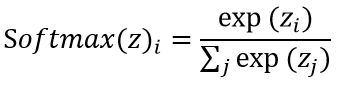

In [ ]:
def relu(Z):
  """
  Performs the ReLU activation.

  Parameters:
    Z (np.array): The linear component of the activation function.

  Returns:
    A (np.array): The activations of the layer.
    activation_cache (np.array): Returns Z, which will be useful for the backpropagation.
  """
  A = np.maximum(0, Z)  # Compare two arrays and return a new array containing the element-wise maxima, unlike np.max
  activation_cache = Z
  return A, activation_cache

In [ ]:
def linear_activation_forward(A_prev, W, B, activation):
  """
  Performs the forward propagation for the linear activation layer.

  Parameters:
    A_prev (np.array): Activations of the previous layer.
    W (np.array): The weights matrix of the current layer.
    B (np.array): The bias vector of the current layer.
    Activation (str): The activation function to be used (either "softmax" or "relu").

  Returns:
    A (np.array): The activations of the current layer.
    cache (tuple): A tuple containing both linear_cache and activation_cache.
  """
  if activation != "softmax" and activation != "relu":
    raise Exception ("Activation function is not exist")

  Z, linear_cache = linear_forward(A_prev, W, B)
  if activation == "softmax":
    A, activation_cache = softmax(Z)  # The matrix A contains only non-negative value

  elif activation == "relu":
    A, activation_cache = relu(Z)  # The matrix A contains only non-negative value

  return A, (linear_cache, activation_cache)

In [ ]:
def apply_batchnorm(A):
  """
  Performs batch normalization on the received activation values of a given layer.

  Parameters:
    A (np.array): The activation values of a given layer.

  Returns:
    NA (np.array): The normalized activation values, based on the formula learned in class.
  """
  epsilon = 1e-8
  mean = np.mean(A, axis=0)
  variance = np.var(A, axis=0)

  # Normalize the activation values using the batchnorm formula
  return (A - mean) / np.sqrt(variance + epsilon)

In [ ]:
def L_model_forward(X, parameters, use_batchnorm=False):
  """
  Performs forward propagation for the [Linear -> RelU] * (L-1) -> Linear -> Softmax computation.

  Parameters:
    X (np.array): The data, numpy array of shape (input size, number of examples).
    parameters (dict): The initialized W and b parameters of each layer.
    use_batchnorm (bool): A boolean flag used to determine whether to apply batchnorm after the activation (set to False by default).

  Returns:
    AL (np.array): The last post-activation value.
    caches (list): A list of all the cache objects generated by the linear_forward function.
  """
  A = X  # The input of the network, i.e., layer 0 (A_0)
  caches = []
  num_of_layers = len(parameters) // 2  # The parameters dictionary contains 2 parameters for each layer (W and B)

  # Forward propagation for [Linear -> RelU] * (L-1)
  # Perform the linear activation forward step using RelU ([Linear -> RelU]) on all but the last layer (= L-1)
  for layer in range(1, num_of_layers):
    W, b = parameters[f"W{layer}"], parameters[f"b{layer}"]
    A, cache = linear_activation_forward(A, W, b, "relu")  # The linear_activation_forward gets A_prev which is the transformed data (output of the previous layer)

    if use_batchnorm is True:
      A = apply_batchnorm(A)
    caches.append(cache)

  # Forward propagation for Linear -> Softmax
  W, b = parameters[f"W{num_of_layers}"], parameters[f"b{num_of_layers}"]  # The parameters of the last layer
  AL, cache = linear_activation_forward(A, W, b, "softmax")  # Perform the linear activation forward step on the last layer using softmax, AL is the probabilities matrix
  caches.append(cache)

  return AL, caches

In [ ]:
def compute_cost(AL, Y):
  """
  Calculates the cost function of categorical cross-entropy loss.
  The formula is as follows:
  cost = (-1 / m) * ∑_1^m ∑_1^C y_i * log⁡(y_hat), where y_i is 1 for the true class ("ground-truth") and y_hat is the softmax-adjusted prediction.

  Parameters:
    AL (np.array): Probability vector corresponding to the label predictions of shape (number of classes, number of examples).
    Y (np.array): The labels vector (i.e. the ground truth).

  Returns:
    cost (float): The categorical cross-entropy cost.
  """
  epsilon = 1e-8
  m = AL.shape[1]  # m is the number of examples in the CCE formula
  cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL + epsilon)))
  return np.squeeze(cost)  # Ensure the cost is a scalar of 1-D array

The formula for categorical cross-entropy for multiple examples is as follows (the mean over all examples is taken):


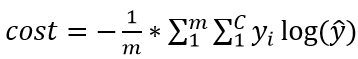


The loss is the average negative log likelihood of the true class labels given the predicted probabilities across all examples.

In [ ]:
def add_L2_cost(parameters):
  """
  Adds the regularization term of L2 norm to the original cost.
  The formula of the updated cost is as follows:
  cost = (ε/2 * w^T * w) + J(w, X, y).

  Parameters:
    parameters (dict): A python dictionary containing the DNN architecture’s parameters.

  Returns:
    cost (float): The addition to the cost after L2 norm.
  """
  epsilon = 1e-8
  regularization_term = 0
  num_of_layers = len(parameters) // 2

  for layer in range(1, num_of_layers + 1):
    curr_w = parameters[f"W{layer}"]
    regularization_term += np.sum(np.matmul(np.transpose(curr_w), curr_w))  # Sum of w^T * w
  regularization_term = (epsilon) * regularization_term
  return np.squeeze(regularization_term)  # Ensure the cost is a scalar of 1-D array

## Section 2 - Backward Propagation Process

In [ ]:
def Linear_backward(dZ, cache):
  """
  Performs the linear part of the backward propagation process for a single layer.

  Parameters:
    dZ (np.array): The gradient of the cost with respect to the linear output of the current layer (layer l) --> ∂L / ∂Z.
    cache (dict): A dictionary with values of (A_prev, W, b) coming from the forward propagation in the current layer.

  Returns:
    dA_prev (np.array): Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev --> ∂L / ∂A_prev.
    dW (np.array): Gradient of the cost with respect to W (current layer l), same shape as W --> ∂L / ∂W.
    db (np.array): Gradient of the cost with respect to b (current layer l), same shape as b --> ∂L / ∂B.
  """
  A_prev, W = cache['A'], cache['W']
  m = A_prev.shape[1]

  # dW == (∂L / ∂A) * (∂A / ∂Z) * (∂Z / ∂W). In details:
  # (∂L / ∂A) * (∂A / ∂Z) == dZ
  # dZ * (∂Z / ∂W) == dZ * [(A_prev * W + B) / ∂W] == dZ * A_prev
  dW = (1 / m) * np.dot(dZ, np.transpose(A_prev))

  # db == (∂L / ∂A) * (∂A / ∂Z) * (∂Z / ∂b). In details:
  # (∂L / ∂A) * (∂A / ∂Z) == dZ
  # dZ * (∂Z / ∂b) == dZ * [(A_prev * W + B) / ∂b] == dZ * 1
  db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)

  # dA_prev == (∂L / ∂A) * (∂A / ∂Z) * (∂Z / ∂A_prev). In details:
  # (∂L / ∂A) * (∂A / ∂Z) == dZ
  # dZ * (∂Z / ∂A_prev) == dZ * [(A_prev * W + B) / ∂A_prev] == dZ * W
  dA_prev = np.dot(np.transpose(W), dZ)

  return dA_prev, dW, db

In [ ]:
def relu_backward(dA, activation_cache):
  """
  Performs backward propagation for a ReLU unit.
  The derivative of ReLU is: f'(x) = 1 if x > 0, otherwise 0.

  Parameters:
    dA (np.array): The post-activation gradient.
    activation_cache (np.array): Contains Z (stored during the forward propagation).

  Returns:
    dZ (np.array): Gradient of the cost with respect to Z.
  """
  # dZ = ∂L / ∂Z == (∂L / ∂A) * (∂A / ∂Z) == dA * σ'(Z)
  # Resets the values in dA that are less than 0 (return dA * 1 if activation_cache > 0, else return dA * 0)
  return np.where(activation_cache > 0, dA, 0)

In [ ]:
def softmax_backward(dA, activation_cache):
  """
  Performs backward propagation for a softmax unit.

  Parameters:
    dA (np.array): The post-activation gradient --> ∂L / ∂A.
    activation_cache (np.array): Contains Z (stored during the forward propagation).

  Returns:
    dZ (np.array): Gradient of the cost with respect to Z --> dZ == ∂L / ∂Z == (∂L / ∂A) * (∂A / ∂Z) == dA * σ'(Z).
  """
  # The derivative of the softmax is: [pred - actual]. 1 is the real class, 0 for all others
  return dA - activation_cache["Y"]  # P_i - Y_i

In [ ]:
def linear_activation_backward(dA, cache, activation):
  """
  Performs the backward propagation for the linear activation layer.
  The function first computes dZ and then applies the linear_backward function.

  Parameters:
    dA (np.array): Post activation gradient of the current layer --> ∂L / ∂A.
    cache (tuple): A tuple containing both linear_cache and activation_cache.
    activation (str): Activation function, either "softmax" or "relu".

  Returns:
    dA_prev (np.array): Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev --> ∂L / ∂A_prev.
    dW (np.array): Gradient of the cost with respect to W (current layer l), same shape as W --> ∂L / ∂W.
    db (np.array): Gradient of the cost with respect to b (current layer l), same shape as b --> ∂L / ∂B.
  """
  if activation != "softmax" and activation != "relu":
    raise Exception ("Activation function is not exist")

  linear_cache, activation_cache = cache[0], cache[1]
  if activation == 'relu':
    dZ = relu_backward(dA, activation_cache)  # The relu_backward needs only the activation cache

  elif activation == 'softmax':
    dZ = softmax_backward(dA, activation_cache)  # The softmax_backward needs only the activation cache

  # Return dA_prev, dW, db
  # dZ is the derivative values of the activation function
  return Linear_backward(dZ, linear_cache)  # The Linear_backward needs only the linear cache

In [ ]:
def L_model_backward(AL, Y, caches):
  """
  Performs the backward propagation process for the entire network.
  The backpropagation for the softmax function should be done only on the output layer, and the ReLU should be done iteratively over all the remaining layers of the network.

  Parameters:
    AL (np.array): The probabilities vector, the output of the forward propagation (L_model_forward).
    Y (np.array): The true labels vector (the "ground truth" - true classifications).
    caches (list): List of linear cache and activation cache of each layer.

  Returns:
    Grads (dict): A dictionary with the gradients: grads[f"dA{layer}"] = ... , grads[f"dW{layer}"] = ... , grads[f"db{layer}"] = ...
  """
  grads = {}
  num_of_layers = len(caches)  # The caches list contains caches for each layer (linear and activation)
  softmax_linear, softmax_activation = caches[-1]
  Z_Y_dict = {"Z": softmax_activation, "Y": Y}  # Z is the value before softmax and Y is the true value

  # Backward propagation for [Linear <- Softmax]
  # Perform the linear_activation_backward on the last layer (with softmax backward)
  dA_prev, dW, db = linear_activation_backward(AL, (softmax_linear, Z_Y_dict), "softmax")
  grads[f"dA{num_of_layers}"] = dA_prev
  grads[f"dW{num_of_layers}"] = dW
  grads[f"db{num_of_layers}"] = db

  # Backward propagation for [Linear <- RelU] * (L-1)
  # Perform the linear_activation_backward on all but the last layer (= L-1) (with relu backward)
  for layer in range(num_of_layers - 1, 0, -1):
    dA_prev, dW, db = linear_activation_backward(dA_prev, caches[layer - 1], "relu")
    grads[f"dA{layer}"] = dA_prev
    grads[f"dW{layer}"] = dW
    grads[f"db{layer}"] = db
  return grads

In [ ]:
def Update_parameters(parameters, grads, learning_rate, L2_norm=False):
  """
  Updates parameters using gradient descent.

  Parameters:
    parameters (dict): A python dictionary containing the DNN architecture’s parameters.
    grads (dict): A python dictionary containing the gradients (generated by L_model_backward).
    learning_rate (float): The learning rate used to update the parameters (the "eta").
    L2_norm (bool): A boolean flag used to determine whether to apply L2 norm (set to False by default).

  Returns:
    parameters (dict): The updated values of the parameters object provided as input.
  """
  num_of_layers = len(parameters) // 2  # The parameters dictionary contains 2 parameters for each layer (W and B)

  if L2_norm:
    epsilon = 1e-8
    for layer in range(1, num_of_layers + 1):  # Iterates over all the layers in the network
      # Adds the regularization term of L2 norm to the original gradient: ∇_w = (ε * w) + ∇_w
      # The formula of the updated weight is as follows:
      #  W = W - η * (ε * w + ∇_w)
      W = parameters[f"W{layer}"]
      parameters[f"W{layer}"] = W - learning_rate * (epsilon * W + grads[f"dW{layer}"])
      parameters[f"b{layer}"] -= learning_rate * grads[f"db{layer}"]

  else:  # Regular update
    # W = W - η * ∇
    # B = B - η * ∇
    for layer in range(1, num_of_layers + 1):  # Iterates over all the layers in the network
      parameters[f"W{layer}"] -= learning_rate * grads[f"dW{layer}"]
      parameters[f"b{layer}"] -= learning_rate * grads[f"db{layer}"]
  return parameters

The function "Update_parameters" also includes the parameter update that takes place when performing L2 regularization.
This regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the squared values of the weights in the cost function, the weights can be made to converge to smaller values. This method leads to a smoother model, where large changes in the input will not cause a drastic change in the output.


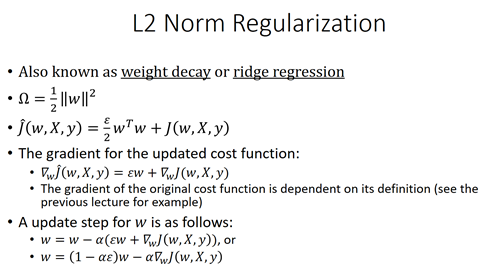

## Section 3 - Training the Network and Producing Predictions

In [ ]:
def accuracy_tracking_and_printing(X_train, Y_train, X_val, Y_val, parameters, epoch, iter, batch_size, use_batchnorm):
  """
  Calculates and prints the accuracy of the training set and validation set with the data of the run (number of epochs, iterations, and batch size).

  Parameters:
    X_train (np.array): The input training data.
    Y_train (np.array): The "real" labels of the training data.
    X_val (np.array): The input validation data.
    Y_val (np.array): The real" labels of the validation data.
    parameters (dict): The updated parameters learned by the network during the training phase.
    epoch (int): Number of epochs.
    iter (int): The iteration number in the current epoch.
    batch_size (int): The batch size.
    use_batchnorm (bool): A boolean flag used to determine whether to apply batchnorm after the activation.
  """
  print(f"\nNumber of epochs: {epoch}")
  print(f"Number of iterations: {iter}")
  print(f"Batch size: {batch_size}")
  print(f"Training Set Accuracy: {round(predict(X_train, Y_train, parameters, use_batchnorm), 3)}")
  print(f"Validation Set Accuracy: {round(predict(X_val, Y_val, parameters, use_batchnorm), 3)}\n")

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, stop_criterion=0.00001, L2_norm=False):
  """
  Performs a L-layer neural network.
  All layers but the last apply the ReLU activation function, and the final layer applies the softmax activation function.
  The size of the output layer is equal to the number of labels in the data.

  Parameters:
    X (np.array): The input data, a numpy array of shape (height * width, number of examples).
    Y (np.array): The "real" labels of the data, a vector of shape (number of classes, number of examples).
    layers_dims (list): A list containing the dimensions of each layer, including the input.
    learning_rate (float): The learning rate used to update the parameters (the "eta").
    num_iterations (int): Specifies the number of epochs.
    batch_size (int): The number of examples in a single training batch.
    use_batchnorm (bool): A boolean flag used to determine whether to apply batchnorm after the activation (set to False by default).
    stop_criterion: Stopping threshold for the difference in validation cost between 100 iterations (set to 0.00001 by default).
    L2_norm (bool): A boolean flag used to determine whether to apply L2 norm (set to False by default).

  Returns:
    parameters (dict): The updated parameters learned by the network during the training phase.
    costs (list): The cost values of training and validation (calculated by the compute_cost function and saved after every 100 training iterations).
  """
  # Train-validation split
  num_of_examples = X.shape[1]  # Number of examples in the data
  val_size = int(num_of_examples * 0.2)  # Determine the size of each validation part
  examples_idx = np.random.permutation(num_of_examples)  # Shuffled array, e.g.: np.random.permutation(4) -> array([1, 3, 0, 2])
  X_train = X[:, examples_idx[val_size:]]  # X_train gets the first 80% of the shuffled examples
  X_val = X[:, examples_idx[:val_size]]  #  X_val gets the last 20% of the shuffled examples
  Y_train = Y[:, examples_idx[val_size:]]  # Y_train gets the first 80% of the shuffled true labels
  Y_val = Y[:, examples_idx[:val_size]]  # Y_train gets the last 20% of the shuffled true labels
  num_of_training_examples = X_train.shape[1]

  # Out of scope parameters
  costs = []
  iter = 1
  checkpoint = 100
  init_val_cost = 99999  # Initialize validation cost with a high cost to prevent early stopping
  parameters = initialize_parameters(layers_dims)  # A dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL)

  for epoch in range(1, num_iterations + 1):  # Each epoch pass through the entire training dataset
    iter = 0
    for batch_start in range(0, num_of_training_examples, batch_size):  # The number of iterations is determined by the number of examples and batch size
      batch_end = min(batch_start + batch_size, num_of_examples)
      batch_X = X_train[:, batch_start:batch_end]
      batch_Y = Y_train[:, batch_start:batch_end]
      # Training the network
      train_AL, train_caches = L_model_forward(batch_X, parameters, use_batchnorm)  # train_AL is the last post-activation value, and caches is a list of the caches of each layer [(l1, a1), (l2, a2), ...]
      grads = L_model_backward(train_AL, batch_Y, train_caches)  # A dictionary with the gradients
      parameters = Update_parameters(parameters, grads, learning_rate, L2_norm)  # The updated values of the parameters
      iter += 1

      # Calculate cost value for training and validation after every 100 training iterations
      if iter % checkpoint == 0:
        train_curr_cost = compute_cost(train_AL, batch_Y)  # The calculation is on only one training batch

        # Running the validation set on the network and calculating the cost
        val_AL, val_caches = L_model_forward(X_val, parameters, use_batchnorm)  # The calculation is always on the entire validation set
        val_curr_cost = compute_cost(val_AL, Y_val)

        if L2_norm:
          L2_cost = add_L2_cost(parameters)  # The regularization term of L2 norm
          train_curr_cost += L2_cost
          val_curr_cost += L2_cost
        costs.append({"Epoch": epoch, "Iteration": iter, "Training Cost": train_curr_cost, "Validation Cost": val_curr_cost})

        try:  # Stop condition
          if abs(val_curr_cost - costs[-2]["Validation Cost"]) < stop_criterion:
            accuracy_tracking_and_printing(X_train, Y_train, X_val, Y_val, parameters, epoch, iter, batch_size, use_batchnorm)
            return parameters, costs
        except:
          if abs(val_curr_cost - init_val_cost) < stop_criterion:
            return parameters, costs

  accuracy_tracking_and_printing(X_train, Y_train, X_val, Y_val, parameters, epoch, iter, batch_size, use_batchnorm)
  return parameters, costs

In [ ]:
def convert_costs_to_csv(costs, csv_name):
  """
  Exports a list of dictionaries to a CSV file, with keys as column names and values as their respective entries.

  Parameters:
    costs (list): List of dictionaries from the same template, where each dictionary shares the same set of keys.
    csv_name (str): The specified name for the CSV file.
  """
  keys = costs[0].keys()
  with open(csv_name, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(costs)

In [ ]:
def predict(X, Y, parameters, use_batchnorm=False):
  """
  Calculates the accuracy of the trained neural network on the provided data.

  Parameters:
    X (np.array): The input data, a numpy array of shape (height*width, number of examples).
    Y (np.array): The "real" labels of the data, a vector of shape (number of classes, number of examples).
    parameters (dict): A python dictionary containing the DNN architecture’s parameters.
    use_batchnorm (bool): A boolean flag used to determine whether to apply batchnorm after the activation (set to False by default).

  Returns:
    accuracy (float): The accuracy measure of the neural network on the provided data (percentage of samples for which the correct label receives the highest confidence score).
  """
  predictions = L_model_forward(X, parameters, use_batchnorm)[0]
  predicted_labels = np.argmax(predictions, axis=0)  # Find the index with the highest probability for each example
  correct_predictions = np.sum(predicted_labels == np.argmax(Y, axis=0))  # Compare predicted labels with true labels
  accuracy = correct_predictions / Y.shape[1]  # Y.shape[1] is the number of examples
  return accuracy

## Section 4 - Classifying the MNIST Dataset

In [ ]:
def load_MNIST_dataset():
  """
  Loads and preprocesses the MNIST dataset.

  Returns:
    X_train_mnist (np.array): Normalized and flattened MNIST training data.
    X_test_mnist (np.array): Normalized and flattened MNIST test data.
    Y_train_mnist (np.array): One-hot encoded MNIST training labels.
    Y_test_mnist (np.array): One-hot encoded MNIST test labels.
  """
  (X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = datasets.mnist.load_data()
  X_train_mnist, X_test_mnist = X_train_mnist / 255.0, X_test_mnist / 255.0  # Normalization pixel values by the maximal value (255) to be between 0 and 1

  # Flatten the images from 28x28 to a 1D array of size 784
  X_train_mnist = X_train_mnist.reshape((X_train_mnist.shape[0], 784)).astype('float32')
  X_test_mnist = X_test_mnist.reshape((X_test_mnist.shape[0], 784)).astype('float32')

  # Convert labels to one-hot encoding
  Y_train_mnist = utils.to_categorical(Y_train_mnist, 10)
  Y_test_mnist = utils.to_categorical(Y_test_mnist, 10)

  return X_train_mnist, X_test_mnist, Y_train_mnist, Y_test_mnist

In [ ]:
def run_the_network(batch_size=128, use_batchnorm=False, stop_criterion=0.00001, L2_norm=False):
  """
  Runs the neural network with the specified configuration.
  Configuration:
  - 4 layers (aside from the input layer) with sizes: 20, 7, 5, 10.
  - Batchnorm is off.
  - Input at each iteration is "flattened" to a matrix of [number of examples, 784].
  - Learning rate: 0.009.
  - Training stops when there is no improvement in the validation set (or the improvement is very small) for the stopping criterion (100 training steps).

  Parameters:
    batch_size (int): The number of examples in a single training batch (set to 128 by default).
    use_batchnorm (bool): A boolean flag used to determine whether to apply batchnorm after the activation (set to False by default).
    stop_criterion: Stopping threshold for the difference in validation cost between 100 iterations (set to 0.00001 by default).
    L2_norm (bool): A boolean flag used to determine whether to apply L2 norm (set to False by default).

  Returns:
    parameters_dict (dict): The updated parameters learned by the network during the training phase.
    costs (list): The cost values of training and validation (calculated by the compute_cost function and saved after every 100 training iterations).
  """
  X_train_mnist, X_test_mnist, Y_train_mnist, Y_test_mnist = load_MNIST_dataset()
  parameters_dict = {}
  start_time = datetime.datetime.now()
  parameters, costs = L_layer_model(np.transpose(X_train_mnist), np.transpose(Y_train_mnist), [784, 20, 7, 5, 10], 0.009, 250, batch_size, use_batchnorm, stop_criterion, L2_norm)

  print(f"Training Time for batch size = {batch_size}, batchnorm = {use_batchnorm}, L2 norm = {L2_norm} is: {datetime.datetime.now() - start_time}")
  accuracy_test = round(predict(np.transpose(X_test_mnist), np.transpose(Y_test_mnist), parameters, use_batchnorm), 3)
  print(f"\nTest Set Accuracy for batch size = {batch_size}, batchnorm = {use_batchnorm}, L2 norm = {L2_norm} is: {accuracy_test}\n")
  parameters_dict[f"{batch_size}_{use_batchnorm}_{L2_norm}"] = parameters
  return parameters_dict, costs

## Sections 5 & 6 - Running the Network Using BatchNorm and L2 Norm

In [ ]:
batchnorm_values = [True, False]
L2_values = [True, False]

for batchnorm_val in batchnorm_values:
    for L2_val in L2_values:
      if not (batchnorm_val and L2_val):
        parameters_dict, costs = run_the_network(128, batchnorm_val, 0.00001, L2_val)
        convert_costs_to_csv(costs, f"Costs_with_Batchnorm_{batchnorm_val}_and_L2_{L2_val}.csv")
        if batchnorm_val is False and L2_val is True:  # Calculate the sum of weights when L2 norm is on
          weights_with_L2 = sum(np.sum(value) for key, value in parameters_dict[f"128_{batchnorm_val}_{L2_val}"].items() if key.startswith('W'))
        elif batchnorm_val is False and L2_val is False:  # Calculate the sum of weights when L2 norm is off
          weights_without_L2 = sum(np.sum(value) for key, value in parameters_dict[f"128_{batchnorm_val}_{L2_val}"].items() if key.startswith('W'))

11490434/11490434 [==============================] - 0s 0us/step

Number of epochs: 124
Number of iterations: 200
Batch size: 128
Training Set Accuracy: 0.807
Validation Set Accuracy: 0.808

Training Time for batch size = 128, batchnorm = True, L2 norm = False is: 0:02:35.429500

Test Set Accuracy for batch size = 128, batchnorm = True, L2 norm = False is: 0.807


Number of epochs: 250
Number of iterations: 375
Batch size: 128
Training Set Accuracy: 0.976
Validation Set Accuracy: 0.935

Training Time for batch size = 128, batchnorm = False, L2 norm = True is: 0:03:58.365775

Test Set Accuracy for batch size = 128, batchnorm = False, L2 norm = True is: 0.932


Number of epochs: 244
Number of iterations: 300
Batch size: 128
Training Set Accuracy: 0.973
Validation Set Accuracy: 0.93

Training Time for batch size = 128, batchnorm = False, L2 norm = False is: 0:03:43.948520

Test Set Accuracy for batch size = 128, batchnorm = False, L2 norm = False is: 0.934



In [ ]:
# print(f"Sum of weights when L2 norm is off: {weights_without_L2}")
# print(f"Sum of weights when L2 norm is on: {weights_with_L2}")

Sum of weights when L2 norm is off :23.23041314592733
Sum of weights when L2 norm is on :18.389714551311187


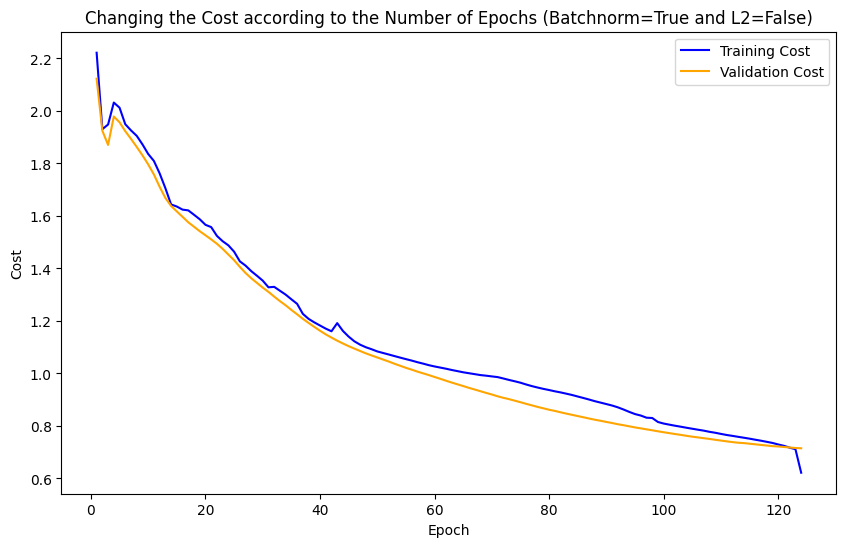

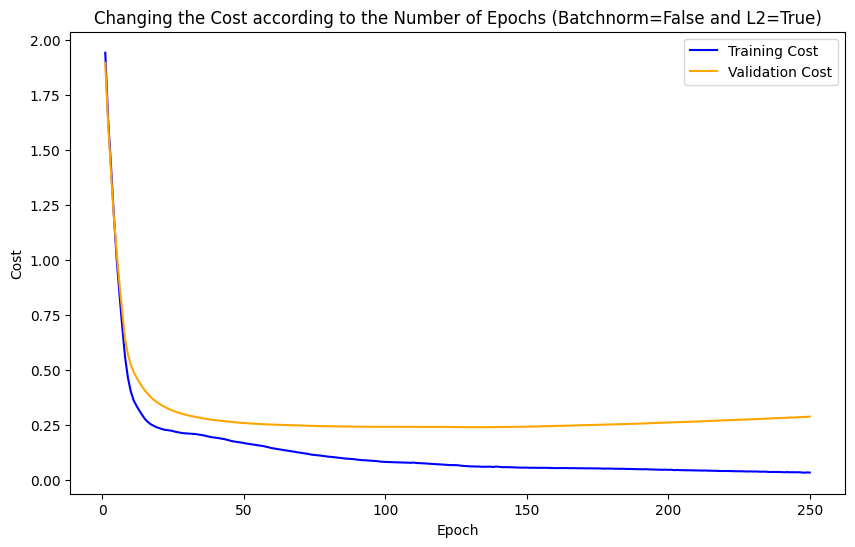

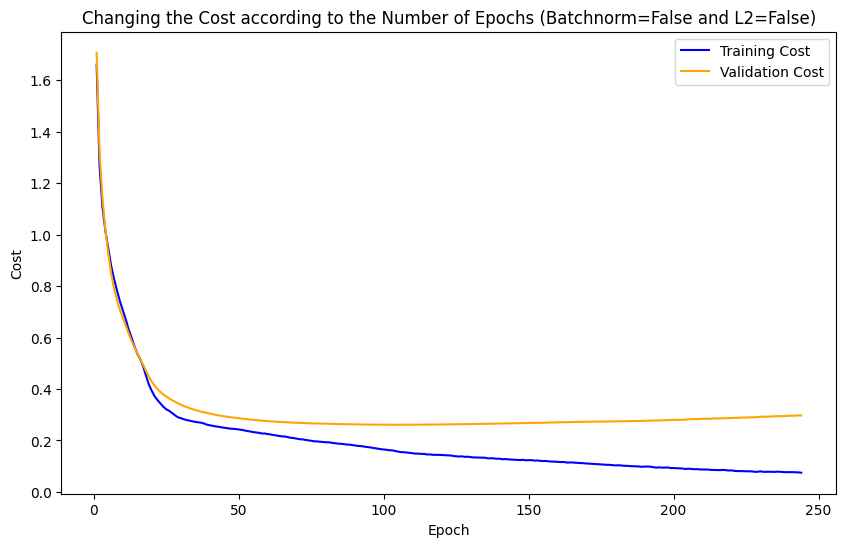

In [ ]:
files = ["Costs_with_Batchnorm_True_and_L2_False",
         "Costs_with_Batchnorm_False_and_L2_True",
         "Costs_with_Batchnorm_False_and_L2_False"]

colors = ['blue', 'orange']
labels = ['Training Cost', 'Validation Cost']

for file in files:
    experiment_df = pd.read_csv(f"{file}.csv")
    cost_per_epoch_df = experiment_df.groupby('Epoch').last().reset_index()

    plt.figure(figsize=(10, 6))
    plt.plot(cost_per_epoch_df['Epoch'], cost_per_epoch_df['Training Cost'], color=colors[0], label=labels[0])
    plt.plot(cost_per_epoch_df['Epoch'], cost_per_epoch_df['Validation Cost'], color=colors[1], label=labels[1])
    plt.xlabel('Epoch')
    plt.ylabel('Cost')

    # Extract the relevant parts and create formatted string
    parts = file.split('_')
    batchnorm_value = parts[3] == 'True'
    l2_value = parts[6] == 'True'
    formatted_string = f"Batchnorm={batchnorm_value} and L2={l2_value}"
    plt.title(f"Changing the Cost according to the Number of Epochs ({formatted_string})")

    plt.legend()
    plt.show()